#### This file contains : Store train data and test data to one HDF5 file. And calculate mean and standard deviation for training data. plot some sample pictures

In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [ ]:
path = "./"

In [ ]:
%matplotlib inline
import h5py    
import numpy as np
import os
from PIL import Image
import glob
from torchvision import transforms
import torch
from matplotlib import pyplot as plt

#### Store data to HDF5 file

In [ ]:
train_root = path + "data/asl/train"
test_root = path + "data/asl/test"
test2_root = path + "data/asl/test2"
classes = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 
           'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 
           'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']
label_map = {}
for id, cl in enumerate(classes):
    label_map[cl] = id

In [ ]:
data_hdf5_root = os.path.join(path, "data/asl/data.hdf5")

In [ ]:
data = []
label = []
for cl in classes:
    for f in glob.glob(os.path.join(train_root, cl, '*.jpg')):
        img = np.asarray(Image.open(f))
        data.append(img)
        label.append(label_map[cl])

data = np.asarray(data)
data_label = np.asarray(label)

In [ ]:
indices = np.random.RandomState(seed=123).permutation(data.shape[0])
train_split = 0.8 # split train and validation as 8:2
train_size = int(train_split * data.shape[0])
train_idx, val_idx = indices[:train_size], indices[train_size:]

train = data[train_idx, :]
train_label = data_label[train_idx]
val = data[val_idx, :]
val_label = data_label[val_idx]
train.shape, train_label.shape, val.shape, val_label.shape

In [ ]:
data = []
label = []
for cl in classes:
    for f in glob.glob(os.path.join(test_root, cl, '*.jpg')):
        img = np.asarray(Image.open(f))
        data.append(img)
        label.append(label_map[cl])

test = np.asarray(data)
test_label = np.asarray(label)
test.shape, test_label.shape

In [ ]:
data = []
label = []
for cl in classes:
    for f in glob.glob(os.path.join(test2_root, cl, '*.jpg')):
        img = Image.open(f).resize((200,200))
        img = np.asarray(img)
        data.append(img)
        label.append(label_map[cl])

test2 = np.asarray(data)
test2_label = np.asarray(label)
test2.shape, test2_label.shape

In [ ]:
with h5py.File(os.path.join(path, 'data/asl/data.hdf5'), 'w') as hf:
    hf.create_dataset('train', data=train)
    hf.create_dataset('train_label', data=train_label)
    hf.create_dataset('val', data=val)
    hf.create_dataset('val_label', data=val_label)
    hf.create_dataset('test', data=test)
    hf.create_dataset('test_label', data=test_label)
    hf.create_dataset('test2', data=test2)
    hf.create_dataset('test2_label', data=test2_label)


#### One way to calculate mean and std

In [ ]:
class HDF5Dataset(torch.utils.data.Dataset):
    def __init__(self, file_path, name, transform=None):
        super().__init__
        self.file_path = file_path
        self.data_cache = {}
        self.transform = transform
        self.name = str(name)
        self.name_label = str(name) + "_label"
        self.size = None
        with h5py.File(file_path, 'r') as hf:
            self.data_cache[self.name] = hf[self.name][:]
            self.data_cache[self.name_label] = hf[self.name_label][:]
            self.size = len(hf[self.name_label])

    def __getitem__(self, index):
        img = self.data_cache[self.name][index]
        if self.transform:
            img = self.transform(img)
        else:
            img = torch.from_numpy(img)

        label = self.data_cache[self.name_label][index]
        return img, label

    def __len__(self):
        return self.size

In [ ]:
data_hdf5_root = os.path.join(path, "data/asl/data.hdf5")
train_dataset = HDF5Dataset(data_hdf5_root, name="train", transform=transforms.ToTensor())

In [ ]:
imgs = torch.stack([img_t for img_t, _ in train_dataset], dim=3)
mean = imgs.view(3, -1).mean(dim=1)
std = imgs.view(3, -1).std(dim=1)
print(mean)
print(std)

#### Another way to calculate mean and std

In [ ]:
device = (torch.device('cuda') if torch.cuda.is_available()
                  else torch.device('cpu'))
print(f"Training on device {device}.")

In [ ]:
with h5py.File(data_hdf5_root, 'r') as hf:
    train = torch.from_numpy(hf['train'][:]).to(device)

In [ ]:
mean = torch.mean(train, dim=(0,1,2)) / 255
std = torch.std(train, dim=(0,1,2)) / 255

#### Plot sample images

In [ ]:
with h5py.File(data_hdf5_root, 'r') as hf:
    train_label = hf['train_label'][:]
    test2_label = hf['test2_label'][:]

dic = {}
train_idx = []
for i, label in enumerate(train_label):
    if(label not in dic):
        train_idx.append(i)
        dic[label] = 1

dic = {}
test2_idx = []
for i, label in enumerate(test2_label):
    if(label not in dic):
        test2_idx.append(i)
        dic[label] = 1

with h5py.File(data_hdf5_root, 'r') as hf:
    train_plot = hf['train'][train_idx]
    test2_plot = hf['test2'][test2_idx]

train_label = train_label[train_idx]
test2_label = test2_label[test2_idx]

In [ ]:
def plot_images(images, rows, cols, labels, classes):
    n_images = len(images)
    fig = plt.figure(figsize=(5, 5))
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        if i >= n_images:
            break
        image = images[i]
        ax.imshow(image)
        ax.set_title(classes[labels[i]])
        ax.axis('off')

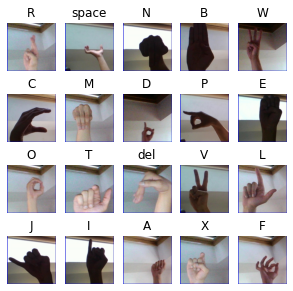

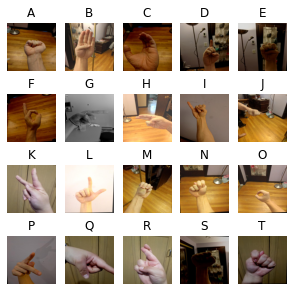

In [ ]:
plot_images(train_plot, 4, 5, train_label, classes)
plot_images(test2_plot, 4, 5, test2_label, classes)